In [ ]:
!pip install -U plotly
!pip install tldextract -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import random
import os
import tldextract

import tensorflow as tf
from tensorflow.python.util import deprecation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc , plot_roc_curve

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 50)
pio.templates.default = "presentation"
pd.options.plotting.backend = "plotly"
deprecation._PRINT_DEPRECATION_WARNINGS = False

     |████████████████████████████████| 25.3 MB 64.0 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 87 kB 2.9 MB/s 


In [ ]:
data = pd.read_csv('data.csv')
data.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [ ]:
val_size = 0.2
train_data, val_data = train_test_split(data, test_size=val_size, stratify=data['label'], random_state=0)

In [ ]:
print(data.label.value_counts())

good    344821
bad      75643
Name: label, dtype: int64


In [ ]:
def parsed_url(url):
    subdomain, domain, domain_suffix = ('<empty>' if extracted == '' else extracted for extracted in tldextract.extract(url))
    return [subdomain, domain, domain_suffix]

def extract_url(data):
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain', 'domain_suffix'])
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)
    return data

data = extract_url(data)
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [ ]:
print('Unique Domains :',data.domain.nunique())
print('Unique Subdomains :',data.subdomain.nunique())
print('Unique Domain Suffixes: ',data.domain_suffix.nunique())

Unique Domains : 114880
Unique Subdomains : 27733
Unique Domain Suffixes:  701


In [ ]:
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())

train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])

print(train_seq[0])

[12, 5, 9, 7, 2, 10, 15, 2, 16, 13, 8, 3, 12, 6, 26, 2, 14, 8, 3, 12, 2, 6, 25, 5, 14, 2, 6, 19, 17, 16, 4, 7, 2, 6, 10, 21, 8, 6, 14, 3, 20, 5, 11, 13, 17, 18, 17]


In [ ]:
sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)

train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)

print(f'{train_seq[0]}')

[12  5  9  7  2 10 15  2 16 13  8  3 12  6 26  2 14  8  3 12  2  6 25  5
 14  2  6 19 17 16  4  7  2  6 10 21  8  6 14  3 20  5 11 13 17 18 17  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    unique_value[feature] = label_index['<unknown>']
    train_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in val_data.loc[:, feature]]

In [ ]:
for data in [train_data, val_data]:
    data.loc[:, 'label'] = [0 if i == 'good' else 1 for i in data.loc[:, 'label']]
    
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,mister-ed.com/welcome/file/update/rbc/login.php,1,0,0,0
1,ip-23-229-147-12.ip.secureserver.net/public/fi...,1,1,1,1
2,facebok-info.com/unitedkingdom/log.php,1,0,2,0
3,independent.co.uk/news/obituaries/john-gross-g...,0,0,3,2
4,facebook.com/geoffrey.gray,0,0,4,0


In [ ]:
def convolution_block(x):
    conv_3_layer = layers.Conv1D(64, 3, padding='same', activation='elu')(x)
    conv_5_layer = layers.Conv1D(64, 5, padding='same', activation='elu')(x)
    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])
    conv_layer = layers.Flatten()(conv_layer)
    return conv_layer

def embedding_block(unique_value, size, name):
    input_layer = layers.Input(shape=(1,), name=name + '_input')
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)
    return input_layer, embedding_layer

def create_model(sequence_length, n_char, unique_value):
    input_layer = []
    
    sequence_input_layer = layers.Input(shape=(sequence_length,), name='url_input')
    input_layer.append(sequence_input_layer)
    
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    conv_layer = convolution_block(char_embedding)
    
    entity_embedding = []
    for key, n in unique_value.items():
        size = 4
        input_l, embedding_l = embedding_block(n + 1, size, key)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)
        
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    
    fc_layer = layers.Dense(128, activation='elu')(fc_layer)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    
    output_layer = layers.Dense(1, activation='sigmoid')(fc_layer)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
    return model

backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

model = create_model(sequence_length, n_char, unique_value)

In [ ]:
train_x = [train_seq, train_data['subdomain'], train_data['domain'], train_data['domain_suffix']]
train_y = train_data['label'].values

early_stopping = [EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=1024, epochs=5, verbose=1, validation_split=0.2, shuffle=True, callbacks=early_stopping)
model.save('model.h5')

Epoch 1/5
263/263 [==============================] - 374s 1s/step - loss: 0.2456 - precision: 0.8349 - recall: 0.5763 - val_loss: 0.1533 - val_precision: 0.8897 - val_recall: 0.7715
Epoch 2/5
263/263 [==============================] - 367s 1s/step - loss: 0.1350 - precision: 0.9051 - recall: 0.7985 - val_loss: 0.1100 - val_precision: 0.9352 - val_recall: 0.8295
Epoch 3/5
263/263 [==============================] - 376s 1s/step - loss: 0.0902 - precision: 0.9367 - recall: 0.8737 - val_loss: 0.0930 - val_precision: 0.9463 - val_recall: 0.8529
Epoch 4/5
263/263 [==============================] - 376s 1s/step - loss: 0.0601 - precision: 0.9597 - recall: 0.9197 - val_loss: 0.0895 - val_precision: 0.9366 - val_recall: 0.8749
Epoch 5/5
263/263 [==============================] - 371s 1s/step - loss: 0.0418 - precision: 0.9726 - recall: 0.9459 - val_loss: 0.0933 - val_precision: 0.9219 - val_recall: 0.8809


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 url_input (InputLayer)         [(None, 161)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 161, 32)      5152        ['url_input[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 161, 64)      6208        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 161, 64)      10304       ['embedding[0][0]']              
                                                                                              

In [ ]:
fig = make_subplots(3, 1, subplot_titles=('loss', 'precision', 'recall'))

for index, key in enumerate(['loss', 'precision', 'recall']):
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history[key]))),
        y=history.history[key],
        mode='lines+markers',
        name=key
    ), index + 1, 1)
    
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history[f'val_{key}']))),
        y=history.history[f'val_{key}'],
        mode='lines+markers',
        name=f'val {key}'
    ), index + 1, 1)

fig.show()

In [ ]:
val_x = [val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
val_y = val_data['label'].values

val_pred = model.predict(val_x)
val_pred_h = np.where(val_pred[:, 0] >= 0.5, 1, 0)

print(f'Validation Data:\n{val_data.label.value_counts()}')
print(f'\n\nConfusion Matrix:\n{confusion_matrix(val_y, val_pred_h)}')
print(f'\n\nClassification Report:\n{classification_report(val_y, val_pred_h)}')

Validation Data:
0    68964
1    15129
Name: label, dtype: int64


Confusion Matrix:
[[67365  1599]
 [ 1046 14083]]


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     68964
           1       0.90      0.93      0.91     15129

    accuracy                           0.97     84093
   macro avg       0.94      0.95      0.95     84093
weighted avg       0.97      0.97      0.97     84093



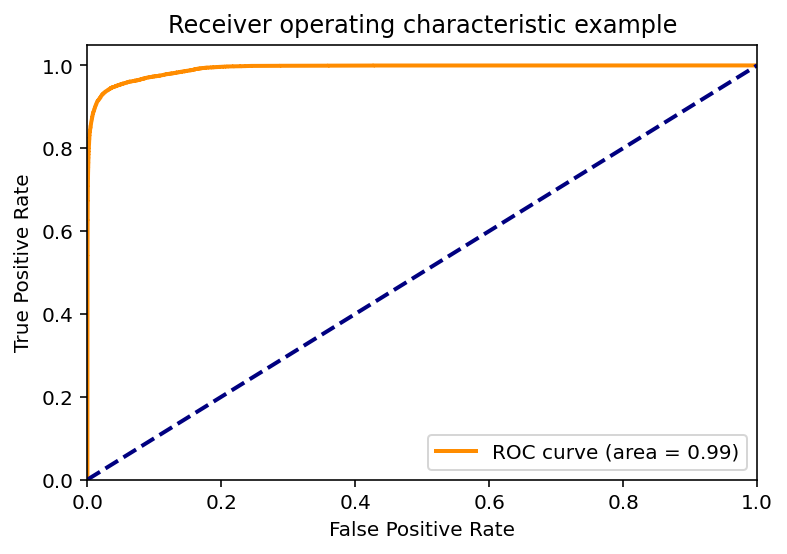

In [ ]:
fpr, tpr, thresholds = roc_curve(val_y, val_pred)
roc_auc=auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()